# Pre-training and Fine-tuning using PyTorch



In [80]:
!pip install torch==2.2.2
!pip install torchtext==0.17.2
!pip install portalocker==2.8.2
!pip install torchdata==0.7.1
!pip install pandas
!pip install matplotlib==3.9.0 scikit-learn==1.5.0
!pip install numpy==1.26.0

In [1]:
from tqdm import tqdm
import time
import numpy as np
import pandas as pd
from itertools import accumulate
import matplotlib.pyplot as plt
import math

import torch
torch.set_num_threads(1)
from torch import nn
import os


from torch.utils.data import DataLoader

from torchtext.datasets import AG_NEWS
from IPython.display import Markdown as md

from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator, GloVe, Vectors, vocab

from torchtext.datasets import IMDB
from torch.utils.data import Dataset
from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset

import pickle

from urllib.request import urlopen
import io

import tarfile
import tempfile

from torch.nn.utils.rnn import pad_sequence

# You can also use this section to suppress warnings generated by your code:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

### Helper Functions

In [2]:
def plot(COST,ACC):

    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.plot(COST, color=color)
    ax1.set_xlabel('epoch', color=color)
    ax1.set_ylabel('total loss', color=color)
    ax1.tick_params(axis='y', color=color)

    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('accuracy', color=color)  # you already handled the x-label with ax1
    ax2.plot(ACC, color=color)
    ax2.tick_params(axis='y', color=color)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped

    plt.show()

In [3]:
def save_list_to_file(lst, filename):
    """
    Save a list to a file using pickle serialization.

    Parameters:
        lst (list): The list to be saved.
        filename (str): The name of the file to save the list to.

    Returns:
        None
    """
    with open(filename, 'wb') as file:
        pickle.dump(lst, file)

def load_list_from_file(filename):
    """
    Load a list from a file using pickle deserialization.

    Parameters:
        filename (str): The name of the file to load the list from.

    Returns:
        list: The loaded list.
    """
    with open(filename, 'rb') as file:
        loaded_list = pickle.load(file)
    return loaded_list

### 1. Positional Encodings

In [4]:
class PositionalEncoding(nn.Module):
    """
    https://pytorch.org/tutorials/beginner/transformer_tutorial.html
    """

    def __init__(self, d_model, vocab_size=5000, dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(vocab_size, d_model)
        position = torch.arange(0, vocab_size, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # shape: (1, d_model, vocab_size)
        self.register_buffer("pe", pe)
        # persisted in the model’s state_dict, not appear in model.parameters() and isn’t updated by optimizers,
        # not require gradients (requires_grad=False), so no backpropagation.

    def forward(self, x):
        x = x + self.pe[:, : x.size(1), :]
        return self.dropout(x)

### 2. Import IMDB dataset

In [5]:
# Opens a connection and returns a file-like HTTP
urlopened = urlopen('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/35t-FeC-2uN1ozOwPs7wFg.gz')
# Reads the bytes into memory and wraps them in a BytesIO buffer. opens it as a tar archive (extraction—no need to save the file locally)
tar = tarfile.open(fileobj=io.BytesIO(urlopened.read()))
# Creates a temporary directory (storing extracted files safely)
tempdir = tempfile.TemporaryDirectory()
# Unpacks all contents
tar.extractall(tempdir.name)
tar.close()

In [6]:
class IMDBDataset(Dataset):
    def __init__(self, root_dir, train=True):
        """
        root_dir: The base directory of the IMDB dataset.
        train: A boolean flag indicating whether to use training or test data.
        """
        self.root_dir = os.path.join(root_dir, "train" if train else "test")
        self.neg_files = [os.path.join(self.root_dir, "neg", f) for f in os.listdir(os.path.join(self.root_dir, "neg")) if f.endswith('.txt')]
        self.pos_files = [os.path.join(self.root_dir, "pos", f) for f in os.listdir(os.path.join(self.root_dir, "pos")) if f.endswith('.txt')]
        self.files = self.neg_files + self.pos_files
        self.labels = [0] * len(self.neg_files) + [1] * len(self.pos_files)
        self.pos_inx=len(self.pos_files)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_path = self.files[idx]
        label = self.labels[idx]
        with open(file_path, 'r', encoding='utf-8') as file:
            content = file.read()
        return label, content

In [7]:
root_dir = tempdir.name + '/' + 'imdb_dataset'
train_iter = IMDBDataset(root_dir=root_dir, train=True)  # For training data
test_iter = IMDBDataset(root_dir=root_dir, train=False)  # For test data

start=train_iter.pos_inx
print(start)

for i in range(-2,2):
    print(train_iter[start+i])

12500
(0, 'In the 60\'s, having as the background the rehearsal and recording of "Sympathy for the Devil" in the classic album "Beggar\'s Banquet" by the revolutionary bad boy Rolling Stones \x96 Mick Jagger, Keith Richards, Charlie Watts, Bill Wyman and Brian Jones \x96 plus Marianne Faithful, Godard discloses other contemporary revolutionary and ideological movements \x96 the Black Power through the Black Panthers, the feminism, the communism, the fascism - entwined with the reading of a cheap pulp political novel divided in the chapters: "The Stones Rolling; "Outside Black Novel"; "Sight and Sound"; "All About Eve"; "The Heart of Occident"; "Inside Black Syntax"; and, "Under the Stones the Beach".<br /><br />"Sympathy for the Devil" is another pretentious and boring mess of the uneven director Jean-Luc Godard. The narrative and the footages are awful, but fortunately I love the Stones and "Sympathy for the Devil" and it is nice to see them in the beginning of their careers; otherwis

In [8]:
imdb_label = {0: " negative review", 1: "positive review"}
num_class = len(set([label for (label, text) in train_iter]))
num_class

2

In [9]:
tokenizer = get_tokenizer("basic_english")

def yield_tokens(data_iter):
    """Yield tokens for each data sample."""
    for _, text in data_iter:
        yield tokenizer(text)

glove_embedding = GloVe(name="6B", dim=100)

vocab = vocab(glove_embedding .stoi, 0,specials=('<unk>', '<pad>'))
vocab.set_default_index(vocab["<unk>"])

def text_pipeline(x):
    return vocab(tokenizer(x))

vocab_size=len(vocab)
vocab_size

.vector_cache/glove.6B.zip: 862MB [03:00, 4.78MB/s]                           
100%|█████████▉| 399999/400000 [00:25<00:00, 15617.96it/s]


400002

### 3. Dataset Splits

In [10]:
train_dataset = to_map_style_dataset(train_iter)
test_dataset = to_map_style_dataset(test_iter)

num_train = int(len(train_dataset) * 0.95)
split_train_, split_valid_ = random_split(train_dataset, [num_train, len(train_dataset) - num_train])

# Due to lack of resources
num_train = int(len(train_dataset) * 0.05)
split_train_, _ = random_split(split_train_, [num_train, len(split_train_) - num_train])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

### 4. Data Loader

In [11]:
def collate_batch(batch):
    label_list, text_list = [], []
    for _label, _text in batch:

        label_list.append(_label)
        text_list.append(torch.tensor(text_pipeline(_text), dtype=torch.int64))

    label_list = torch.tensor(label_list, dtype=torch.int64)
    text_list = pad_sequence(text_list, batch_first=True)

    return label_list.to(device), text_list.to(device)

In [12]:
BATCH_SIZE = 32

train_dataloader = DataLoader(split_train_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)
valid_dataloader = DataLoader(split_valid_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)

### 5. Neural Network

In [13]:
class Net(nn.Module):
    """
    Text classifier based on a pytorch TransformerEncoder.
    """
    def __init__(self, num_class, vocab_size, freeze=True, nhead=2, dim_feedforward=128, num_layers=2, dropout=0.1, activation="relu", classifier_dropout=0.1):
        super().__init__()
        self.emb = nn.Embedding.from_pretrained(glove_embedding.vectors,freeze=freeze)
        embedding_dim = self.emb.embedding_dim
        self.pos_encoder = PositionalEncoding(d_model=embedding_dim, dropout=dropout, vocab_size=vocab_size)
        encoder_layer = nn.TransformerEncoderLayer(d_model=embedding_dim, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.classifier = nn.Linear(embedding_dim, num_class)
        self.d_model = embedding_dim

    def forward(self, x):
        x = self.emb(x) * math.sqrt(self.d_model)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)
        x = self.classifier(x)
        return x

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Net(num_class=2,vocab_size=vocab_size).to(device)
model

Net(
  (emb): Embedding(400000, 100)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=100, out_features=100, bias=True)
        )
        (linear1): Linear(in_features=100, out_features=128, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=128, out_features=100, bias=True)
        (norm1): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (classifier): Linear(in_features=100, out_features=2, bias=True)
)

In [15]:
def predict(text, text_pipeline, model):
    with torch.no_grad():
        text = torch.unsqueeze(torch.tensor(text_pipeline(text)),0).to(device)
        model.to(device)
        output = model(text)
        return imdb_label[output.argmax(1).item()]

def evaluate(dataloader, model_eval):
    model_eval.eval()
    total_acc, total_count= 0, 0
    with torch.no_grad():
        for label, text in tqdm(dataloader):
            label, text = label.to(device), text.to(device)
            output = model_eval(text)
            predicted = torch.max(output.data, 1)[1]
            total_acc += (predicted == label).sum().item()
            total_count += label.size(0)
    return total_acc / total_count

def evaluate_no_tqdm(dataloader, model_eval):
    model_eval.eval()
    total_acc, total_count= 0, 0

    with torch.no_grad():
        for label, text in dataloader:
            label, text = label.to(device), text.to(device)
            output = model_eval(text)
            predicted = torch.max(output.data, 1)[1]
            total_acc += (predicted == label).sum().item()
            total_count += label.size(0)
    return total_acc / total_count

### 6. Training

In [16]:
def train_model(model, optimizer, criterion, train_dataloader, valid_dataloader,  epochs=1000, save_dir="", file_name=None):
    cum_loss_list = []
    acc_epoch = []
    acc_old = 0
    model_path = os.path.join(save_dir, file_name)
    acc_dir = os.path.join(save_dir, os.path.splitext(file_name)[0] + "_acc")
    loss_dir = os.path.join(save_dir, os.path.splitext(file_name)[0] + "_loss")
    time_start = time.time()

    for epoch in tqdm(range(1, epochs + 1)):
        model.train()
        #print(model)
        #for parm in model.parameters():
        #    print(parm.requires_grad)
        cum_loss = 0
        for idx, (label, text) in enumerate(train_dataloader):
            optimizer.zero_grad()
            label, text = label.to(device), text.to(device)

            predicted_label = model(text)
            loss = criterion(predicted_label, label)
            loss.backward()
            #print(loss)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
            optimizer.step()
            cum_loss += loss.item()
        print(f"Epoch {epoch}/{epochs} - Loss: {cum_loss}")

        cum_loss_list.append(cum_loss)
        accu_val = evaluate_no_tqdm(valid_dataloader,model)
        acc_epoch.append(accu_val)

        if model_path and accu_val > acc_old:
            print(accu_val)
            acc_old = accu_val
            if save_dir is not None:
                pass
                #print("save model epoch",epoch)
                #torch.save(model.state_dict(), model_path)
                #save_list_to_file(lst=acc_epoch, filename=acc_dir)
                #save_list_to_file(lst=cum_loss_list, filename=loss_dir)

    time_end = time.time()
    print(f"Training time: {time_end - time_start}")

In [17]:
LR=1
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
save_dir = ""
file_name = "model_IMDB dataset small2.pth"
train_model(model=model,  optimizer=optimizer, criterion=criterion, train_dataloader=train_dataloader, valid_dataloader=valid_dataloader,
            epochs=2, save_dir=save_dir, file_name=file_name)

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1/2 - Loss: 31.194925129413605


 50%|█████     | 1/2 [00:54<00:54, 54.16s/it]

0.4896
Epoch 2/2 - Loss: 30.76280015707016


100%|██████████| 2/2 [01:48<00:00, 54.24s/it]

0.5104
Training time: 108.47812247276306


 Model trained on full dataset and with 100 epochs:

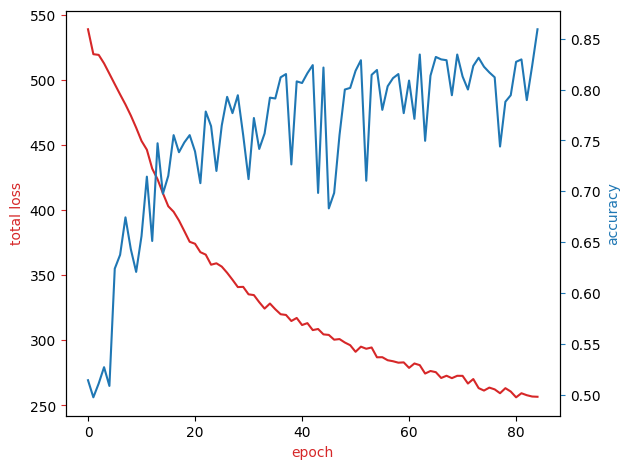

In [18]:
acc_urlopened = urlopen('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/sybqacL5p1qeEO8d4xRZNg/model-IMDB%20dataset%20small2-acc')
loss_urlopened = urlopen('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/eOt6woGoaOB565T0RLH5WA/model-IMDB%20dataset%20small2-loss')
acc_epoch = pickle.load(acc_urlopened)
cum_loss_list = pickle.load(loss_urlopened)
plot(cum_loss_list,acc_epoch)

In [19]:
urlopened = urlopen('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/q66IH6a7lglkZ4haM6hB1w/model-IMDB%20dataset%20small2.pth')
model_ = Net(vocab_size=vocab_size, num_class=2).to(device)
model_.load_state_dict(torch.load(io.BytesIO(urlopened.read()), map_location=device))
evaluate(test_dataloader, model_)

100%|██████████| 782/782 [04:29<00:00,  2.90it/s]


0.83

## Fine-tune Model Pretrained on the AG News Dataset

In [20]:
train_iter_ag_news = AG_NEWS(split="train")

num_class_ag_news = len(set([label for (label, text) in train_iter_ag_news ]))
print("num_class_ag_news:", num_class_ag_news)

train_iter_ag_news, test_iter_ag_news = AG_NEWS()
train_dataset_ag_news = to_map_style_dataset(train_iter_ag_news)
test_dataset_ag_news = to_map_style_dataset(test_iter_ag_news)

num_train_ag_news = int(len(train_dataset_ag_news) * 0.95)
split_train_ag_news_, split_valid_ag_news_ = random_split(train_dataset_ag_news, [num_train_ag_news, len(train_dataset_ag_news) - num_train_ag_news])


num_train_ag_news = int(len(train_dataset_ag_news) * 0.05)
split_train_ag_news_, _ = random_split(split_train_ag_news_, [num_train_ag_news, len(split_train_ag_news_) - num_train_ag_news])


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def label_pipeline(x):
   return int(x) - 1

def collate_batch_ag_news(batch):
    label_list, text_list = [], []
    for _label, _text in batch:
        label_list.append(label_pipeline(_label))
        text_list.append(torch.tensor(text_pipeline(_text), dtype=torch.int64))
    label_list = torch.tensor(label_list, dtype=torch.int64)
    text_list = pad_sequence(text_list, batch_first=True)
    return label_list.to(device), text_list.to(device)

BATCH_SIZE = 32
train_dataloader_ag_news = DataLoader(split_train_ag_news_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch_ag_news)
valid_dataloader_ag_news = DataLoader(split_valid_ag_news_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch_ag_news)
test_dataloader_ag_news = DataLoader(test_dataset_ag_news, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch_ag_news)

model_ag_news = Net(num_class=4,vocab_size=vocab_size).to(device)
model_ag_news.to(device)

# LR=1
# criterion = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model_ag_news.parameters(), lr=LR)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
# save_dir = ""
# file_name = "model_AG News small1.pth"
# train_model(model=model_ag_news, optimizer=optimizer, criterion=criterion, train_dataloader=train_dataloader_ag_news, valid_dataloader=valid_dataloader_ag_news,  epochs=2, save_dir=save_dir, file_name=file_name)


num_class_ag_news: 4


Net(
  (emb): Embedding(400000, 100)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=100, out_features=100, bias=True)
        )
        (linear1): Linear(in_features=100, out_features=128, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=128, out_features=100, bias=True)
        (norm1): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (classifier): Linear(in_features=100, out_features=4, bias=True)
)

 Model trained on the full AG News dataset and with 100 epochs:

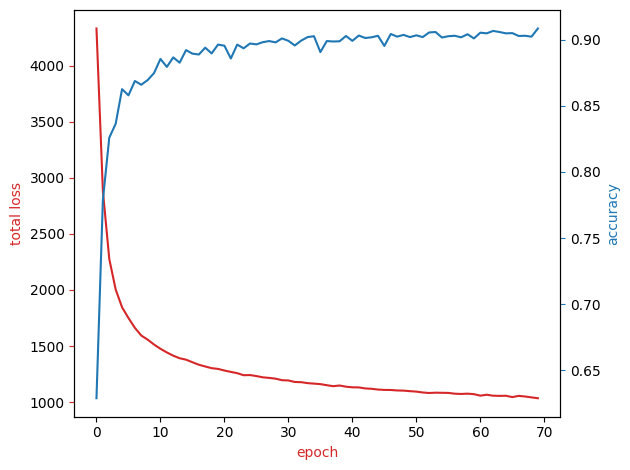

In [21]:
acc_urlopened = urlopen('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/bQk8mJu3Uct3I4JEsEtRnw/model-AG%20News%20small1-acc')
loss_urlopened = urlopen('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/KNQkqJWWwY_XfbFBRFhZNA/model-AG%20News%20small1-loss')
acc_epoch = pickle.load(acc_urlopened)
cum_loss_list = pickle.load(loss_urlopened)
plot(cum_loss_list,acc_epoch)

In [22]:
urlopened = urlopen('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/9c3Dh2O_jsYBShBuchUNlg/model-AG%20News%20small1.pth')
model_ag_news_ = Net(vocab_size=vocab_size, num_class=4).to(device)
model_ag_news_.load_state_dict(torch.load(io.BytesIO(urlopened.read()), map_location=device))
evaluate(test_dataloader_ag_news, model_ag_news_)

100%|██████████| 238/238 [00:08<00:00, 28.38it/s]


0.9035526315789474

### Fine-tuning AG News Model on IMDB Data

In [23]:
urlopened = urlopen('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/9c3Dh2O_jsYBShBuchUNlg/model-AG%20News%20small1.pth')
model_fine1 = Net(vocab_size=vocab_size, num_class=4).to(device)
model_fine1.load_state_dict(torch.load(io.BytesIO(urlopened.read()), map_location=device))

<All keys matched successfully>

In [24]:
in_features = model_fine1.classifier.in_features
print("Original final layer:", model_fine1.classifier)
print("Input dimention  final layer:", in_features)

Original final layer: Linear(in_features=100, out_features=4, bias=True)
Input dimention  final layer: 100


In [25]:
model_fine1.classifier = nn.Linear(in_features, 2)
model_fine1.to(device)

Net(
  (emb): Embedding(400000, 100)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=100, out_features=100, bias=True)
        )
        (linear1): Linear(in_features=100, out_features=128, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=128, out_features=100, bias=True)
        (norm1): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (classifier): Linear(in_features=100, out_features=2, bias=True)
)

In [26]:
for name, param in model_fine1.named_parameters():
    print(f"{name} requires_grad: {param.requires_grad}")

emb.weight requires_grad: False
transformer_encoder.layers.0.self_attn.in_proj_weight requires_grad: True
transformer_encoder.layers.0.self_attn.in_proj_bias requires_grad: True
transformer_encoder.layers.0.self_attn.out_proj.weight requires_grad: True
transformer_encoder.layers.0.self_attn.out_proj.bias requires_grad: True
transformer_encoder.layers.0.linear1.weight requires_grad: True
transformer_encoder.layers.0.linear1.bias requires_grad: True
transformer_encoder.layers.0.linear2.weight requires_grad: True
transformer_encoder.layers.0.linear2.bias requires_grad: True
transformer_encoder.layers.0.norm1.weight requires_grad: True
transformer_encoder.layers.0.norm1.bias requires_grad: True
transformer_encoder.layers.0.norm2.weight requires_grad: True
transformer_encoder.layers.0.norm2.bias requires_grad: True
transformer_encoder.layers.1.self_attn.in_proj_weight requires_grad: True
transformer_encoder.layers.1.self_attn.in_proj_bias requires_grad: True
transformer_encoder.layers.1.sel

In [27]:
LR=1
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_fine1.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
save_dir = ""
file_name = "model_fine1.pth"
train_model(model=model_fine1, optimizer=optimizer, criterion=criterion, train_dataloader=train_dataloader, valid_dataloader=valid_dataloader,  epochs=2,  save_dir=save_dir ,file_name=file_name )

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1/2 - Loss: 27.811688482761383


 50%|█████     | 1/2 [01:05<01:05, 65.71s/it]

0.5016
Epoch 2/2 - Loss: 27.8526571393013


100%|██████████| 2/2 [02:18<00:00, 69.47s/it]

0.5472
Training time: 138.94597053527832


Model fine-tuned on the full IMDB training set for 100 epochs:

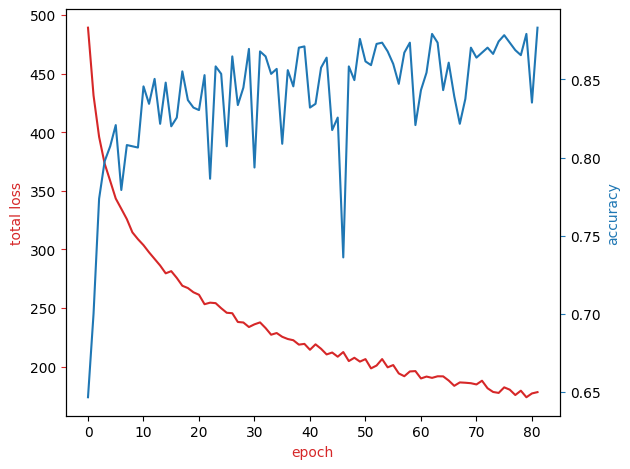

In [28]:
acc_urlopened = urlopen('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/3LEJw8BRgJJFGqlLxaETxA/model-fine1-acc')
loss_urlopened = urlopen('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/-CT1h97vjv0TolY82Nw29g/model-fine1-loss')
acc_epoch = pickle.load(acc_urlopened)
cum_loss_list = pickle.load(loss_urlopened)
plot(cum_loss_list,acc_epoch)

In [29]:
urlopened = urlopen('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/e0WOHKh5dnrbC2lGhpsMMw/model-fine1.pth')
model_fine1_ = Net(vocab_size=vocab_size, num_class=2).to(device)
model_fine1_.load_state_dict(torch.load(io.BytesIO(urlopened.read()), map_location=device))
evaluate(test_dataloader, model_fine1_)

100%|██████████| 782/782 [04:24<00:00,  2.96it/s]


0.85964

### Fine-tune the Final Layer Only

In [30]:
urlopened = urlopen('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/9c3Dh2O_jsYBShBuchUNlg/model-AG%20News%20small1.pth')
model_fine2 = Net(vocab_size=vocab_size, num_class=4).to(device)
model_fine2.load_state_dict(torch.load(io.BytesIO(urlopened.read()), map_location=device))

<All keys matched successfully>

In [31]:
for param in model_fine2.parameters():
    param.requires_grad = False

In [32]:
# the new layer will be unfrozen
dim=model_fine2.classifier.in_features
model_fine2.classifier = nn.Linear(dim, 2)
model_fine2.to(device)

Net(
  (emb): Embedding(400000, 100)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=100, out_features=100, bias=True)
        )
        (linear1): Linear(in_features=100, out_features=128, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=128, out_features=100, bias=True)
        (norm1): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (classifier): Linear(in_features=100, out_features=2, bias=True)
)

In [33]:
LR=1
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_fine2.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
save_dir = ""
file_name = "model_fine2.pth"
train_model(model=model_fine2, optimizer=optimizer, criterion=criterion, train_dataloader=train_dataloader, valid_dataloader=valid_dataloader,  epochs=2,  save_dir=save_dir ,file_name=file_name )

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1/2 - Loss: 28.052803993225098


 50%|█████     | 1/2 [00:29<00:29, 29.35s/it]

0.5352
Epoch 2/2 - Loss: 27.927562057971954


100%|██████████| 2/2 [00:59<00:00, 29.56s/it]

0.5528
Training time: 59.117533683776855


Model fine-tuned on the full IMDB training set for 100 epochs:

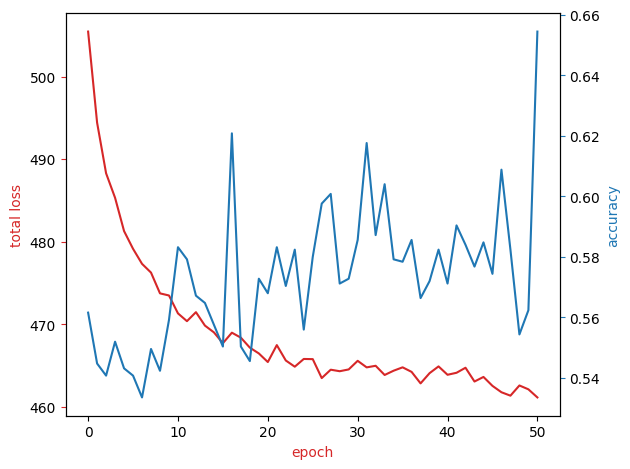

In [34]:
acc_urlopened = urlopen('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/UdR3ApQnxSeV2mrA0CbiLg/model-fine2-acc')
loss_urlopened = urlopen('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/rWGDIF-uL2dEngWcIo9teQ/model-fine2-loss')
acc_epoch = pickle.load(acc_urlopened)
cum_loss_list = pickle.load(loss_urlopened)
plot(cum_loss_list,acc_epoch)

In [35]:
urlopened = urlopen('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/B-1H6lpDg-A0zRwpB6Ek2g/model-fine2.pth')
model_fine2_ = Net(vocab_size=vocab_size, num_class=2).to(device)
model_fine2_.load_state_dict(torch.load(io.BytesIO(urlopened.read()), map_location=device))
evaluate(test_dataloader, model_fine2_)

100%|██████████| 782/782 [04:24<00:00,  2.96it/s]


0.6388

### Unfreeze Specific Layers for Fine-tuning

In [36]:
model_finetune_some_layers = Net(num_class=4,vocab_size=vocab_size).to(device)

for param in model_finetune_some_layers.parameters():
    param.requires_grad = False

model_finetune_some_layers

Net(
  (emb): Embedding(400000, 100)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=100, out_features=100, bias=True)
        )
        (linear1): Linear(in_features=100, out_features=128, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=128, out_features=100, bias=True)
        (norm1): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (classifier): Linear(in_features=100, out_features=4, bias=True)
)

In [37]:
for i in range(2):
    for param in model_finetune_some_layers.transformer_encoder.layers[i].linear2.parameters():
        param.requires_grad = True

model_finetune_some_layers.classifier  = nn.Linear(100, 3)

for name, param in model_finetune_some_layers.named_parameters():
    print(f"{name} requires_grad: {param.requires_grad}")

emb.weight requires_grad: False
transformer_encoder.layers.0.self_attn.in_proj_weight requires_grad: False
transformer_encoder.layers.0.self_attn.in_proj_bias requires_grad: False
transformer_encoder.layers.0.self_attn.out_proj.weight requires_grad: False
transformer_encoder.layers.0.self_attn.out_proj.bias requires_grad: False
transformer_encoder.layers.0.linear1.weight requires_grad: False
transformer_encoder.layers.0.linear1.bias requires_grad: False
transformer_encoder.layers.0.linear2.weight requires_grad: True
transformer_encoder.layers.0.linear2.bias requires_grad: True
transformer_encoder.layers.0.norm1.weight requires_grad: False
transformer_encoder.layers.0.norm1.bias requires_grad: False
transformer_encoder.layers.0.norm2.weight requires_grad: False
transformer_encoder.layers.0.norm2.bias requires_grad: False
transformer_encoder.layers.1.self_attn.in_proj_weight requires_grad: False
transformer_encoder.layers.1.self_attn.in_proj_bias requires_grad: False
transformer_encoder.

## Adapters

In [38]:
class FeatureAdapter(nn.Module):
    """
    Attributes:
        size (int): The bottleneck dimension to which the embeddings are temporarily reduced.
        model_dim (int): The original dimension of the embeddings or features in the transformer model.
    """
    def __init__(self, bottleneck_size=50, model_dim=100):
        super().__init__()
        self.bottleneck_transform = nn.Sequential(
            nn.Linear(model_dim, bottleneck_size),  # Down-project to a smaller dimension
            nn.ReLU(),                             # Apply non-linearity
            nn.Linear(bottleneck_size, model_dim)  # Up-project back to the original dimension
        )

    def forward(self, x):
        """
        Forward pass of the FeatureAdapter. Applies the bottleneck transformation to the input
        tensor and adds a skip connection.

        Args:
            x (Tensor): Input tensor with shape (batch_size, seq_length, model_dim).

        Returns:
            Tensor: Output tensor after applying the adapter transformation and skip connection,
                    maintaining the original input shape.
        """
        transformed_features = self.bottleneck_transform(x)  # Transform features through the bottleneck
        output_with_residual = transformed_features + x      # Add the residual connection
        return output_with_residual

In [39]:
class Adapted(nn.Module):
    def __init__(self, linear,bottleneck_size=None):
        super(Adapted, self).__init__()
        self.linear = linear
        model_dim = linear.out_features
        if bottleneck_size is None:
          bottleneck_size = model_dim//2   # Define default bottleneck size as half the model_dim

        # Initialize FeatureAdapter with calculated bottleneck_size and model_dim
        self.adaptor = FeatureAdapter(bottleneck_size=bottleneck_size, model_dim=model_dim)

    def forward(self, x):
        # First, the input x is passed through the linear layer
        x=self.linear(x)
        # Then it's adapted using FeatureAdapter
        x= self.adaptor(x)
        return x

In [40]:
urlopened = urlopen('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/9c3Dh2O_jsYBShBuchUNlg/model-AG%20News%20small1.pth')
model_adapters = Net(vocab_size=vocab_size, num_class=4).to(device)
model_adapters.load_state_dict(torch.load(io.BytesIO(urlopened.read()), map_location=device))

<All keys matched successfully>

In [41]:
for param in model_adapters.parameters():
    param.requires_grad = False

dim= model_adapters.classifier.in_features
model_adapters.classifier = nn.Linear(dim, 2)

In [42]:
my_example_layer=model_adapters.transformer_encoder.layers[0].linear1
print(my_example_layer)

my_adapeted_layer=Adapted(my_example_layer)
print(my_adapeted_layer)

for parm in my_adapeted_layer.parameters():
    print(parm.requires_grad)

Linear(in_features=100, out_features=128, bias=True)
Adapted(
  (linear): Linear(in_features=100, out_features=128, bias=True)
  (adaptor): FeatureAdapter(
    (bottleneck_transform): Sequential(
      (0): Linear(in_features=128, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=128, bias=True)
    )
  )
)
False
False
True
True
True
True


A systematic approach to traverse the model and replace specific layers with the adapter layer:

In [43]:
N_layers=len(model_adapters.transformer_encoder.layers)

In [44]:
for n in range(N_layers):
  encoder=model_adapters.transformer_encoder.layers[n]
  if encoder.linear1:
    print(" before linear1")
    print(encoder.linear1)
    model_adapters.transformer_encoder.layers[n].linear1=Adapted(encoder.linear1, bottleneck_size=24)
    print(" after  linear1")
    print(model_adapters.transformer_encoder.layers[n].linear1)

  if encoder.linear2:
    print(" before linear2")
    print(model_adapters.transformer_encoder.layers[n].linear2)
    model_adapters.transformer_encoder.layers[n].linear2=Adapted(encoder.linear2, bottleneck_size=24)
    print(" after linear2")
    print(model_adapters.transformer_encoder.layers[n].linear2)

 before linear1
Linear(in_features=100, out_features=128, bias=True)
 after  linear1
Adapted(
  (linear): Linear(in_features=100, out_features=128, bias=True)
  (adaptor): FeatureAdapter(
    (bottleneck_transform): Sequential(
      (0): Linear(in_features=128, out_features=24, bias=True)
      (1): ReLU()
      (2): Linear(in_features=24, out_features=128, bias=True)
    )
  )
)
 before linear2
Linear(in_features=128, out_features=100, bias=True)
 after linear2
Adapted(
  (linear): Linear(in_features=128, out_features=100, bias=True)
  (adaptor): FeatureAdapter(
    (bottleneck_transform): Sequential(
      (0): Linear(in_features=100, out_features=24, bias=True)
      (1): ReLU()
      (2): Linear(in_features=24, out_features=100, bias=True)
    )
  )
)
 before linear1
Linear(in_features=100, out_features=128, bias=True)
 after  linear1
Adapted(
  (linear): Linear(in_features=100, out_features=128, bias=True)
  (adaptor): FeatureAdapter(
    (bottleneck_transform): Sequential(
     

In [45]:
model_adapters.to(device)

Net(
  (emb): Embedding(400000, 100)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=100, out_features=100, bias=True)
        )
        (linear1): Adapted(
          (linear): Linear(in_features=100, out_features=128, bias=True)
          (adaptor): FeatureAdapter(
            (bottleneck_transform): Sequential(
              (0): Linear(in_features=128, out_features=24, bias=True)
              (1): ReLU()
              (2): Linear(in_features=24, out_features=128, bias=True)
            )
          )
        )
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Adapted(
          (linear): Linear(in_features=128, out_features=100, bias=True)
          (adaptor): FeatureAdapter(
            (bottleneck_transform): 

In [46]:
LR=1
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_adapters.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
save_dir = ""
file_name = "model_adapters.pth"
train_model(model=model_adapters, optimizer=optimizer, criterion=criterion, train_dataloader=train_dataloader, valid_dataloader=valid_dataloader,  epochs=2,  save_dir=save_dir ,file_name=file_name )

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1/2 - Loss: 28.049696922302246


 50%|█████     | 1/2 [00:48<00:48, 48.48s/it]

0.5104
Epoch 2/2 - Loss: 28.189769983291626


100%|██████████| 2/2 [01:36<00:00, 48.37s/it]

Training time: 96.74435424804688


An adapted model fine-tuned on the full IMDB dataset for 100 epochs

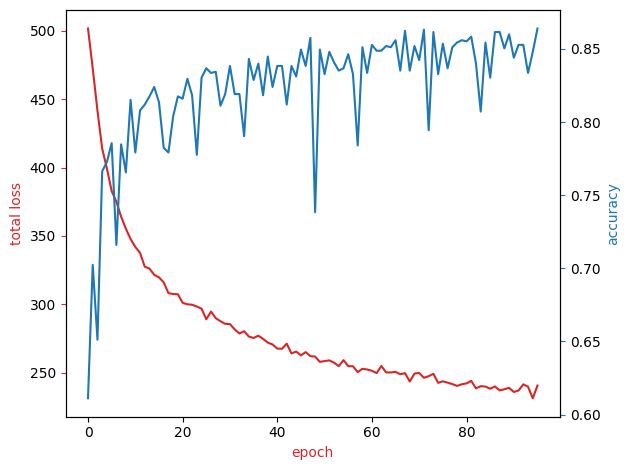

In [47]:
acc_urlopened = urlopen('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/D49zrrMPWO_ktwQo7PSHIQ/model-adapters-acc')
loss_urlopened = urlopen('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/RXWlmyaco695RiaoU7QsnA/model-adapters-loss')
acc_epoch = pickle.load(acc_urlopened)
cum_loss_list = pickle.load(loss_urlopened)
plot(cum_loss_list,acc_epoch)

In [48]:
model_adapters_ = Net(vocab_size=vocab_size, num_class=2).to(device)
for n in range(N_layers):
  encoder=model_adapters_.transformer_encoder.layers[n]
  if encoder.linear1:
    print(" before linear1")
    print(encoder.linear1)
    model_adapters_.transformer_encoder.layers[n].linear1=Adapted(encoder.linear1, bottleneck_size=24)
    print(" after  linear1")
    print(model_adapters_.transformer_encoder.layers[n].linear1)

  if encoder.linear2:
    print(" before linear2")
    print(model_adapters_.transformer_encoder.layers[n].linear2)
    model_adapters_.transformer_encoder.layers[n].linear2=Adapted(encoder.linear2, bottleneck_size=24)
    print(" after linear2")
    print(model_adapters_.transformer_encoder.layers[n].linear2)

model_adapters_.to(device)
for param in model_adapters_.parameters():
    param.requires_grad = False

urlopened = urlopen('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/PGhd5G_NVrWNH-_jdjwNlw/model-adapters.pth')
model_adapters_.load_state_dict(torch.load(io.BytesIO(urlopened.read()), map_location=device))
evaluate(test_dataloader, model_adapters_)

 before linear1
Linear(in_features=100, out_features=128, bias=True)
 after  linear1
Adapted(
  (linear): Linear(in_features=100, out_features=128, bias=True)
  (adaptor): FeatureAdapter(
    (bottleneck_transform): Sequential(
      (0): Linear(in_features=128, out_features=24, bias=True)
      (1): ReLU()
      (2): Linear(in_features=24, out_features=128, bias=True)
    )
  )
)
 before linear2
Linear(in_features=128, out_features=100, bias=True)
 after linear2
Adapted(
  (linear): Linear(in_features=128, out_features=100, bias=True)
  (adaptor): FeatureAdapter(
    (bottleneck_transform): Sequential(
      (0): Linear(in_features=100, out_features=24, bias=True)
      (1): ReLU()
      (2): Linear(in_features=24, out_features=100, bias=True)
    )
  )
)
 before linear1
Linear(in_features=100, out_features=128, bias=True)
 after  linear1
Adapted(
  (linear): Linear(in_features=100, out_features=128, bias=True)
  (adaptor): FeatureAdapter(
    (bottleneck_transform): Sequential(
     

100%|██████████| 782/782 [05:21<00:00,  2.43it/s]


0.85804

## Adapt linear layers in a different network

In [49]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

exercise_model = NeuralNetwork()

exercise_model.to(device)
for param in exercise_model.parameters():
    param.requires_grad = False

print(exercise_model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [50]:
exercise_model.linear_relu_stack[0] = Adapted(exercise_model.linear_relu_stack[0], bottleneck_size=30)
exercise_model.linear_relu_stack[2] = Adapted(exercise_model.linear_relu_stack[2], bottleneck_size=30)
exercise_model.linear_relu_stack[4] = nn.Linear(512, 5)
print(exercise_model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Adapted(
      (linear): Linear(in_features=784, out_features=512, bias=True)
      (adaptor): FeatureAdapter(
        (bottleneck_transform): Sequential(
          (0): Linear(in_features=512, out_features=30, bias=True)
          (1): ReLU()
          (2): Linear(in_features=30, out_features=512, bias=True)
        )
      )
    )
    (1): ReLU()
    (2): Adapted(
      (linear): Linear(in_features=512, out_features=512, bias=True)
      (adaptor): FeatureAdapter(
        (bottleneck_transform): Sequential(
          (0): Linear(in_features=512, out_features=30, bias=True)
          (1): ReLU()
          (2): Linear(in_features=30, out_features=512, bias=True)
        )
      )
    )
    (3): ReLU()
    (4): Linear(in_features=512, out_features=5, bias=True)
  )
)


## Low-Rank Adaptation (LoRA)

In [53]:
class TextClassifier(nn.Module):
    def __init__(self, num_classes,freeze=False):
        super(TextClassifier, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(glove_embedding.vectors.to(device),freeze=freeze)
        # An example of adding additional layers: A linear layer and a ReLU activation
        self.fc1 = nn.Linear(in_features=100, out_features=128)
        self.relu = nn.ReLU()
        # The output layer that gives the final probabilities for the classes
        self.fc2 = nn.Linear(in_features=128, out_features=num_classes)

    def forward(self, x):
        # Pass the input through the embedding layer
        x = self.embedding(x)
        # Here you can use a simple mean pooling

        x = torch.mean(x, dim=1)
        # Pass the pooled embeddings through the additional layers
        x = self.fc1(x)
        x = self.relu(x)
        return self.fc2(x)

In [54]:
class LoRALayer(torch.nn.Module):
    def __init__(self, in_dim, out_dim, rank, alpha):
        super().__init__()
        std_dev = 1 / torch.sqrt(torch.tensor(rank).float())
        self.A = torch.nn.Parameter(torch.randn(in_dim, rank) * std_dev)
        self.B = torch.nn.Parameter(torch.zeros(rank, out_dim))
        self.alpha = alpha
    def forward(self, x):
        x = self.alpha * (x @ self.A @ self.B)
        return x

class LinearWithLoRA(torch.nn.Module):
    def __init__(self, linear, rank, alpha):
        super().__init__()
        self.linear = linear.to(device)
        self.lora = LoRALayer(linear.in_features, linear.out_features, rank, alpha).to(device)
    def forward(self, x):
        return self.linear(x) + self.lora(x)

In [55]:
from urllib.request import urlopen
import io

model_lora=TextClassifier(num_classes=4,freeze=False)
model_lora.to(device)

urlopened = urlopen('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/uGC04Pom651hQs1XrZ0NsQ/my-model-freeze-false.pth')

stream = io.BytesIO(urlopened.read())
state_dict = torch.load(stream, map_location=device)
model_lora.load_state_dict(state_dict)

for parm in model_lora.parameters():
    parm.requires_grad=False
model_lora

TextClassifier(
  (embedding): Embedding(400000, 100)
  (fc1): Linear(in_features=100, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=4, bias=True)
)

In [56]:
model_lora.fc2=nn.Linear(in_features=128, out_features=2, bias=True).to(device)
model_lora.fc1=LinearWithLoRA(model_lora.fc1,rank=2, alpha=0.1).to(device)

model_lora.to(device)

TextClassifier(
  (embedding): Embedding(400000, 100)
  (fc1): LinearWithLoRA(
    (linear): Linear(in_features=100, out_features=128, bias=True)
    (lora): LoRALayer()
  )
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

### Choose `alpha` and `rank`

In [62]:
ranks = [1, 2, 5]
alphas = [0.1, 0.5, 1.0]

results=[]
accuracy_old=0
for r in ranks:
    for alpha in alphas:
        print(f"Testing with rank = {r} and alpha = {alpha}")
        model_name=f"model_lora_rank{r}_alpha{alpha}_AGtoIBDM_final_adam_"
        optimizer = torch.optim.Adam(model_lora.parameters(), lr=LR)
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.1)
        model_lora.to(device)
        train_model(model_lora, optimizer, criterion, train_dataloader, valid_dataloader, epochs=3, file_name=model_name)
        accuracy=evaluate(valid_dataloader ,  model_lora)
        result = {'rank': r, 'alpha': alpha, 'accuracy':accuracy}
        results.append(result)
        if accuracy>accuracy_old:
            print(f"Testing with rank = {r} and alpha = {alpha}")
            print(f"accuracy: {accuracy} accuracy_old: {accuracy_old}" )
            accuracy_old=accuracy

Testing with rank = 1 and alpha = 0.1


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1/3 - Loss: 30.902452886104584


 33%|███▎      | 1/3 [00:01<00:02,  1.44s/it]

0.4896
Epoch 2/3 - Loss: 31.029621064662933


 67%|██████▋   | 2/3 [00:02<00:01,  1.14s/it]

0.5104
Epoch 3/3 - Loss: 28.818726181983948


100%|██████████| 3/3 [00:03<00:00,  1.11s/it]


Training time: 3.3256704807281494


100%|██████████| 40/40 [00:00<00:00, 90.83it/s]


Testing with rank = 1 and alpha = 0.1
accuracy: 0.5104 accuracy_old: 0
Testing with rank = 1 and alpha = 0.5


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1/3 - Loss: 32.30701917409897


 33%|███▎      | 1/3 [00:00<00:01,  1.06it/s]

0.5104
Epoch 2/3 - Loss: 29.44979465007782


 67%|██████▋   | 2/3 [00:01<00:00,  1.05it/s]

Epoch 3/3 - Loss: 28.427041232585907


100%|██████████| 3/3 [00:02<00:00,  1.06it/s]


Training time: 2.848735809326172


100%|██████████| 40/40 [00:00<00:00, 90.64it/s]


Testing with rank = 1 and alpha = 1.0


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1/3 - Loss: 29.459428012371063


 33%|███▎      | 1/3 [00:01<00:02,  1.11s/it]

0.4896
Epoch 2/3 - Loss: 29.73733389377594


 67%|██████▋   | 2/3 [00:02<00:01,  1.31s/it]

Epoch 3/3 - Loss: 28.92471420764923


100%|██████████| 3/3 [00:03<00:00,  1.30s/it]


Training time: 3.9159398078918457


100%|██████████| 40/40 [00:00<00:00, 88.46it/s]


Testing with rank = 2 and alpha = 0.1


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1/3 - Loss: 28.96253788471222


 33%|███▎      | 1/3 [00:00<00:01,  1.06it/s]

0.4896
Epoch 2/3 - Loss: 28.763935029506683


 67%|██████▋   | 2/3 [00:01<00:00,  1.04it/s]

Epoch 3/3 - Loss: 29.15530574321747


100%|██████████| 3/3 [00:02<00:00,  1.06it/s]


0.5104
Training time: 2.844553232192993


100%|██████████| 40/40 [00:00<00:00, 86.65it/s]


Testing with rank = 2 and alpha = 0.5


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1/3 - Loss: 29.871440708637238


 33%|███▎      | 1/3 [00:00<00:01,  1.09it/s]

0.5104
Epoch 2/3 - Loss: 29.2050621509552


 67%|██████▋   | 2/3 [00:01<00:00,  1.09it/s]

Epoch 3/3 - Loss: 30.958339631557465


100%|██████████| 3/3 [00:02<00:00,  1.09it/s]


Training time: 2.7614524364471436


100%|██████████| 40/40 [00:00<00:00, 91.64it/s]


Testing with rank = 2 and alpha = 1.0


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1/3 - Loss: 28.72001552581787


 33%|███▎      | 1/3 [00:00<00:01,  1.09it/s]

0.4896
Epoch 2/3 - Loss: 29.133289873600006


 67%|██████▋   | 2/3 [00:01<00:00,  1.09it/s]

Epoch 3/3 - Loss: 29.089548468589783


100%|██████████| 3/3 [00:02<00:00,  1.09it/s]


0.5104
Training time: 2.76019024848938


100%|██████████| 40/40 [00:00<00:00, 56.29it/s]


Testing with rank = 5 and alpha = 0.1


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1/3 - Loss: 30.667824804782867


 33%|███▎      | 1/3 [00:01<00:02,  1.44s/it]

0.4896
Epoch 2/3 - Loss: 28.967578053474426


 67%|██████▋   | 2/3 [00:02<00:01,  1.36s/it]

Epoch 3/3 - Loss: 30.078318536281586


100%|██████████| 3/3 [00:03<00:00,  1.22s/it]


Training time: 3.6630454063415527


100%|██████████| 40/40 [00:00<00:00, 89.15it/s]


Testing with rank = 5 and alpha = 0.5


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1/3 - Loss: 29.528734147548676


 33%|███▎      | 1/3 [00:00<00:01,  1.08it/s]

0.5104
Epoch 2/3 - Loss: 31.35931771993637


 67%|██████▋   | 2/3 [00:01<00:00,  1.07it/s]

Epoch 3/3 - Loss: 34.59687089920044


100%|██████████| 3/3 [00:02<00:00,  1.08it/s]


Training time: 2.7936782836914062


100%|██████████| 40/40 [00:00<00:00, 90.56it/s]


Testing with rank = 5 and alpha = 1.0


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1/3 - Loss: 50.350055515766144


 33%|███▎      | 1/3 [00:00<00:01,  1.08it/s]

0.4896
Epoch 2/3 - Loss: 29.962496638298035


 67%|██████▋   | 2/3 [00:01<00:00,  1.08it/s]

0.5104
Epoch 3/3 - Loss: 28.25354564189911


100%|██████████| 3/3 [00:02<00:00,  1.08it/s]


Training time: 2.794748306274414


100%|██████████| 40/40 [00:00<00:00, 92.81it/s]


In [63]:
LR=1
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_lora.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)

model_name="model_lora_final2"
train_model(model_lora,optimizer, criterion, train_dataloader, valid_dataloader, epochs=2, file_name=model_name)

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1/2 - Loss: 27.97387146949768


 50%|█████     | 1/2 [00:01<00:01,  1.95s/it]

0.5104
Epoch 2/2 - Loss: 27.88892263174057


100%|██████████| 2/2 [00:03<00:00,  1.59s/it]

Training time: 3.192864418029785


LoRA model pretrained on 300 epochs:

In [64]:
%%capture
!wget https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/JWPRb1RMhKLRMUWOKw9pxA/model-lora-final2.pth
!wget https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/_dm02rLyTrwsXEQh2r32sQ/model-lora-final2-acc.pkl
!wget https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/OZbVqKjoqOSIwnET8AB1KA/model-lora-final2-loss.pkl

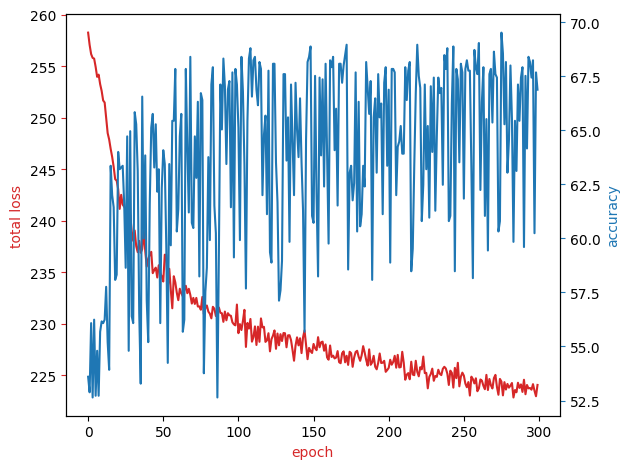

In [65]:
cum_loss_list=load_list_from_file(model_name.replace('_','-') + "-loss.pkl")
acc_epoch=load_list_from_file(model_name.replace('_','-') + "-acc.pkl")
plot(cum_loss_list,acc_epoch)

In [66]:
model_lora.load_state_dict(torch.load(model_name.replace('_','-') + ".pth", map_location=device))
model_lora.eval()

TextClassifier(
  (embedding): Embedding(400000, 100)
  (fc1): LinearWithLoRA(
    (linear): Linear(in_features=100, out_features=128, bias=True)
    (lora): LoRALayer()
  )
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

In [68]:
evaluate(test_dataloader , model_lora)

100%|██████████| 782/782 [00:10<00:00, 78.14it/s]


0.69144

In [69]:
B=model_lora.fc1.lora.B
print("B",B)
print("\n Number of elements in the tensor B",B.numel())
torch.save(B, 'B.pth')

B Parameter containing:
tensor([[-4.3192e-01, -1.1071e+00,  2.4456e-01, -3.1031e-02, -2.0012e-01,
         -6.7811e-01, -1.3552e-01, -2.7458e-01,  3.2278e-02,  6.7592e-02,
          8.3020e-01,  1.1610e-05, -1.0894e-01,  7.7830e-05, -1.6789e-01,
         -1.3309e-01, -5.1875e-01,  2.1928e-02, -6.5869e-02, -3.5834e-01,
         -2.4473e-02, -1.1260e+00, -8.8752e-02, -7.0861e-03, -1.3263e-02,
          0.0000e+00, -6.9039e-01, -8.6471e-02, -3.9146e-01, -2.2644e-01,
         -8.7611e-01, -7.9929e-01,  0.0000e+00,  3.9646e-01,  5.2164e-01,
         -4.2730e-01,  2.3550e-01,  4.0447e-02,  2.3289e-01, -4.5217e-01,
          1.7721e-03, -4.7263e-01, -2.4343e-01,  6.3737e-01,  0.0000e+00,
          2.6904e-03, -7.8828e-01,  2.2559e-02, -4.3776e-02,  3.0909e-01,
         -1.6914e-01, -2.0294e-01, -4.2175e-01,  7.8840e-01, -3.1771e-01,
         -2.0639e-01,  1.1487e-02, -5.7238e-01,  1.4071e-01, -2.8561e-01,
          1.1753e-01, -1.6501e-04, -4.5406e-01,  0.0000e+00,  6.4464e-05,
         -4.45

In [70]:
A=model_lora.fc1.lora.A
print("A",A)
print("\n Number of elements in the tensor A",A.numel())
torch.save(A, 'A.pth')

A Parameter containing:
tensor([[ 3.2952e-01,  9.3019e-01],
        [ 2.3904e+00, -5.1022e+00],
        [-2.4573e-01,  2.4733e+00],
        [ 5.8014e-01,  3.9014e-01],
        [ 1.6970e+00, -2.4614e+00],
        [-1.2420e+00,  8.3014e-01],
        [-2.0468e+00,  1.1629e+00],
        [-5.9361e-01,  1.8099e-01],
        [ 9.2466e-02,  1.1583e-01],
        [-2.0841e-02,  1.5550e+00],
        [ 1.3028e+00, -9.8381e-01],
        [ 1.4320e+00, -3.3497e+00],
        [-1.1637e+00,  1.9436e+00],
        [ 2.4898e-01, -1.1353e+00],
        [ 2.4423e+00,  1.0154e+00],
        [ 2.4881e+00, -4.6765e+00],
        [-1.8985e-01,  1.3426e+00],
        [-1.1730e-01, -2.1925e+00],
        [ 2.0193e+00, -8.5886e-01],
        [-3.1268e+00,  3.5134e+00],
        [ 1.0935e+00, -2.9263e+00],
        [-1.0435e+00,  2.5428e-01],
        [-8.6704e-01,  2.3570e+00],
        [-5.2725e-02, -2.3731e-01],
        [-4.3896e+00,  5.0369e+00],
        [-1.1174e+00,  9.9728e-01],
        [ 4.7710e-01, -1.2162e+00],
    

In [71]:
alfa_=model_lora.fc1.lora.alpha
torch.save(alfa_, 'alfa_.pth')
torch.save(model_lora.fc2.state_dict(), 'out_layer.pth')

### Loading the model

In [72]:
A = torch.load('A.pth')
print("A:",A.shape)

B = torch.load('B.pth')
print("B:",B.shape)

alfa_ = torch.load('alfa_.pth')
alfa_

A: torch.Size([100, 2])
B: torch.Size([2, 128])


0.1

In [73]:
output_layer=nn.Linear(in_features=128, out_features=2, bias=True)
output_layer.load_state_dict(torch.load('out_layer.pth'))

<All keys matched successfully>

In [74]:
model_load_lora = TextClassifier(num_classes=4,freeze=False)
model_load_lora.to(device)

urlopened = urlopen('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/uGC04Pom651hQs1XrZ0NsQ/my-model-freeze-false.pth')

stream = io.BytesIO(urlopened.read())
state_dict = torch.load(stream, map_location=device)
model_load_lora.load_state_dict(state_dict)

model_load_lora

TextClassifier(
  (embedding): Embedding(400000, 100)
  (fc1): Linear(in_features=100, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=4, bias=True)
)

In [75]:
model_load_lora.fc1=LinearWithLoRA(model_load_lora.fc1,rank=2, alpha=0.1)
model_load_lora.fc2=nn.Linear(in_features=128, out_features=2, bias=True).to(device)

model_load_lora.fc1.lora.A=A
model_load_lora.fc1.lora.B=B
model_load_lora.fc1.lora.alpha=alfa_
model_load_lora.fc2=output_layer

model_load_lora.to(device)
model_load_lora.eval()

TextClassifier(
  (embedding): Embedding(400000, 100)
  (fc1): LinearWithLoRA(
    (linear): Linear(in_features=100, out_features=128, bias=True)
    (lora): LoRALayer()
  )
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

In [76]:
evaluate(test_dataloader , model_load_lora)

100%|██████████| 782/782 [00:09<00:00, 83.78it/s]


0.69148

In [78]:
article="""This was a lacklustre movie with very little going for it. I was not impressed."""

result = predict(article, text_pipeline, model_load_lora)

markdown_content = f'''
<div style="background-color: lightgray; padding: 10px;">
    <h3>{article}</h3>
    <h4>The category of the news article: {result}</h4>
</div>
'''

md(markdown_content)


<div style="background-color: lightgray; padding: 10px;">
    <h3>This was a lacklustre movie with very little going for it. I was not impressed.</h3>
    <h4>The category of the news article:  negative review</h4>
</div>


### Apply LoRA to a hand-written digits identifier

In [79]:
class NNet(nn.Module):

    def __init__(self):
        super(NNet, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # 5*5 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, input):
        # Convolution layer C1: 1 input image channel, 6 output channels,
        # 5x5 square convolution, it uses RELU activation function, and
        # outputs a Tensor with size (N, 6, 28, 28), where N is the size of the batch
        c1 = F.relu(self.conv1(input))
        # Subsampling layer S2: 2x2 grid, purely functional,
        # this layer does not have any parameter, and outputs a (N, 6, 14, 14) Tensor
        s2 = F.max_pool2d(c1, (2, 2))
        # Convolution layer C3: 6 input channels, 16 output channels,
        # 5x5 square convolution, it uses RELU activation function, and
        # outputs a (N, 16, 10, 10) Tensor
        c3 = F.relu(self.conv2(s2))
        # Subsampling layer S4: 2x2 grid, purely functional,
        # this layer does not have any parameter, and outputs a (N, 16, 5, 5) Tensor
        s4 = F.max_pool2d(c3, 2)
        # Flatten operation: purely functional, outputs a (N, 400) Tensor
        s4 = torch.flatten(s4, 1)
        # Fully connected layer F5: (N, 400) Tensor input,
        # and outputs a (N, 120) Tensor, it uses RELU activation function
        f5 = F.relu(self.fc1(s4))
        # Fully connected layer F6: (N, 120) Tensor input,
        # and outputs a (N, 84) Tensor, it uses RELU activation function
        f6 = F.relu(self.fc2(f5))
        # Gaussian layer OUTPUT: (N, 84) Tensor input, and
        # outputs a (N, 10) Tensor
        output = self.fc3(f6)
        return output

model_exercise = NNet()
model_exercise.to(device)

print('This is what the model looked like before applying LoRA:')
print(model_exercise)
print("\n###############\n")

# Freeze all parameters:
for parm in model_exercise.parameters():
    parm.requires_grad=False

# Change final layer for one with 26 outputs:
model_exercise.fc3=nn.Linear(in_features=84, out_features=26, bias=True).to(device)

# Apply LoRA to the second linear layer
model_exercise.fc2=LinearWithLoRA(model_exercise.fc2,rank=2, alpha=0.1).to(device)

print('This is what the model looked like after applying LoRA:')
print(model_exercise)

This is what the model looked like before applying LoRA:
NNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

###############

This is what the model looked like after applying LoRA:
NNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): LinearWithLoRA(
    (linear): Linear(in_features=120, out_features=84, bias=True)
    (lora): LoRALayer()
  )
  (fc3): Linear(in_features=84, out_features=26, bias=True)
)
